# 5 - Results
In this notebook, we will create plots for all the conditions and RNAs in our dataset. Some of these figure were also used in the publication linked to this dataset. 

## 5.1 - Load data

In [1]:
import sys
from glob import glob
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import re
from matplotlib.ticker import MaxNLocator
import logging
import seaborn as sns

In [47]:
conditions = [
    {'label': 'LB', 'mu': 2.3},
    {'label': 'GLU', 'mu': 0.54},
    {'label': 'GLY', 'mu': 0.32},
    {'label': 'GAL', 'mu': 0.17},
    {'label': 'MAN', 'mu': 0.12},
]

conditions_ordered = [c['label'] for c in conditions]
conditions_ordered

['LB', 'GLU', 'GLY', 'GAL', 'MAN']

In [23]:
logging.basicConfig(format='%(asctime)s [%(levelname)s] %(message)s ', datefmt='%m/%d/%Y %I:%M:%S%p', level=logging.INFO)
rootdir = "../tests/output-5conditions"
logging.info(f'reading from directory {rootdir}')

dfs = []
for f in list(Path(rootdir).glob('*/results.csv')):
    logging.info(f'..loading file: {f}')
    df = pd.read_csv(f)
    dfs.append(df)
df = pd.concat(dfs).reset_index()
df.rename(columns={'index': 'cell_image_id'}, inplace=True)
df.rename(columns={'Unnamed: 0': 'cell_unique_id'}, inplace=True)
df['cell_unique_id'] = df.index
df['condition'] = df['condition'].apply(lambda c: re.sub('[_-].*', '', c))

10/04/2024 11:59:34AM [INFO] reading from directory ../tests/output-5conditions 
10/04/2024 11:59:34AM [INFO] ..loading file: ../tests/output-5conditions/MG1655_LB_01/results.csv 
10/04/2024 11:59:34AM [INFO] ..loading file: ../tests/output-5conditions/MG1655_MAN_OD_0.3_left_05/results.csv 
10/04/2024 11:59:34AM [INFO] ..loading file: ../tests/output-5conditions/MG1655_GLU_OD_0.3_left_02/results.csv 
10/04/2024 11:59:34AM [INFO] ..loading file: ../tests/output-5conditions/MG1655_GLY-lowOD-2nd_15/results.csv 
10/04/2024 11:59:34AM [INFO] ..loading file: ../tests/output-5conditions/MG1655_GAL-lowOD-2nd_06/results.csv 


In [3]:
df

,cell_image_id,cell_unique_id,strain,condition,seqnr,mRNA,label,bbox-0,bbox-1,bbox-2,bbox-3,area,eccentricity,spots_per_cell,dense_regions_per_cell,decomposed_RNAs,tx_per_cell,nascent_RNAs,nuclei,total_RNAs_per_cell
0,0,0,MG1655,LB,1,hipBA,1,0,879,23,896,305.0,0.797556,0,0,0,0,0,0,0
1,1,1,MG1655,LB,1,hipBA,2,0,1159,13,1178,201.0,0.671268,0,0,0,0,0,1,0
2,2,2,MG1655,LB,1,hipBA,3,0,1281,33,1307,609.0,0.828168,0,0,0,0,0,2,0
3,3,3,MG1655,LB,1,hipBA,4,0,1611,36,1643,660.0,0.907338,0,0,0,0,0,3,0
4,4,4,MG1655,LB,1,hipBA,5,0,1659,40,1705,936.0,0.916651,0,0,0,0,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18226,3862,18226,MG1655,GAL-lowOD-2nd,6,rpoD,1285,2264,435,2297,454,500.0,0.839785,0,0,0,0,0,0,0
18227,3863,18227,MG1655,GAL-lowOD-2nd,6,rpoD,1286,2265,451,2304,479,533.0,0.950938,0,0,0,0,0,1,0
18228,3864,18228,MG1655,GAL-lowOD-2nd,6,rpoD,1287,2265,1442,2299,1472,610.0,0.844544,0,0,0,0,0,0,0
18229,3865,18229,MG1655,GAL-lowOD-2nd,6,rpoD,1288,2267,1272,2293,1301,518.0,0.792364,0,0,0,0,0,0,0


In [26]:
# inspect data
df.columns

Index(['cell_image_id', 'cell_unique_id', 'strain', 'condition', 'seqnr',
       'mRNA', 'label', 'bbox-0', 'bbox-1', 'bbox-2', 'bbox-3', 'area',
       'eccentricity', 'spots_per_cell', 'dense_regions_per_cell',
       'decomposed_RNAs', 'tx_per_cell', 'nascent_RNAs', 'nuclei',
       'total_RNAs_per_cell'],
      dtype='object')

In [27]:
mRNAs = df['mRNA'].unique()
conditions = df['condition'].unique()
strains = df['strain'].unique()
seqnrs = df['seqnr'].unique() 
mRNAs, conditions, strains, seqnrs

(array(['hipBA', 'rnlAB', 'rpoD'], dtype=object),
 array(['LB', 'MAN', 'GLU', 'GLY', 'GAL'], dtype=object),
 array(['MG1655'], dtype=object),
 array([ 1,  5,  2, 15,  6]))

### Checking cell ids:

In [29]:
df.groupby(['strain', 'condition', 'seqnr'])['cell_image_id'].min()


strain  condition  seqnr
MG1655  GAL        6        0
        GLU        2        0
        GLY        15       0
        LB         1        0
        MAN        5        0
Name: cell_image_id, dtype: int64

In [30]:
df.groupby(['strain', 'condition', 'seqnr'])['cell_unique_id'].min()


strain  condition  seqnr
MG1655  GAL        6        14364
        GLU        2         5571
        GLY        15       12234
        LB         1            0
        MAN        5         3729
Name: cell_unique_id, dtype: int64

In [31]:
df.groupby(['strain', 'condition', 'seqnr'])['cell_unique_id'].max()


strain  condition  seqnr
MG1655  GAL        6        18230
        GLU        2        12233
        GLY        15       14363
        LB         1         3728
        MAN        5         5570
Name: cell_unique_id, dtype: int64

### Cells per condition:

In [53]:
df.groupby(['strain', 'condition', 'seqnr']).size()


strain  condition  seqnr
MG1655  GAL        6        3867
        GLU        2        6663
        GLY        15       2130
        LB         1        3729
        MAN        5        1842
dtype: int64

### Cell area:

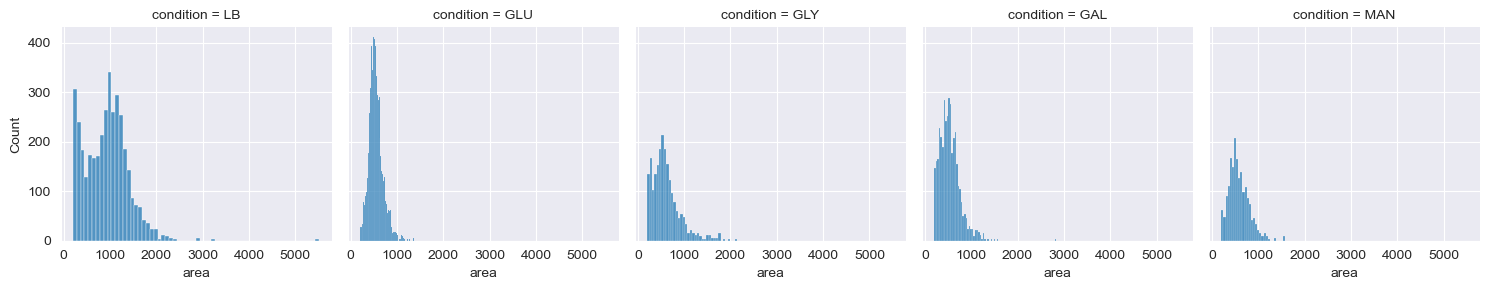

In [51]:
g = sns.FacetGrid(df, col='condition', col_order=conditions_ordered)
g.map_dataframe(sns.histplot, x='area');

### Cell eccentricity:

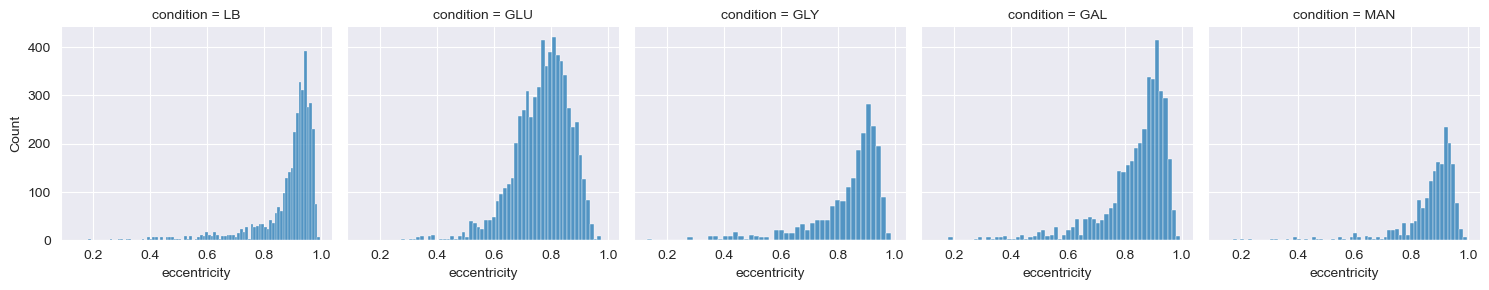

In [49]:
g = sns.FacetGrid(df, col='condition', col_order=conditions_ordered)
g.map_dataframe(sns.histplot, x='eccentricity');

### mRNAs per cell:

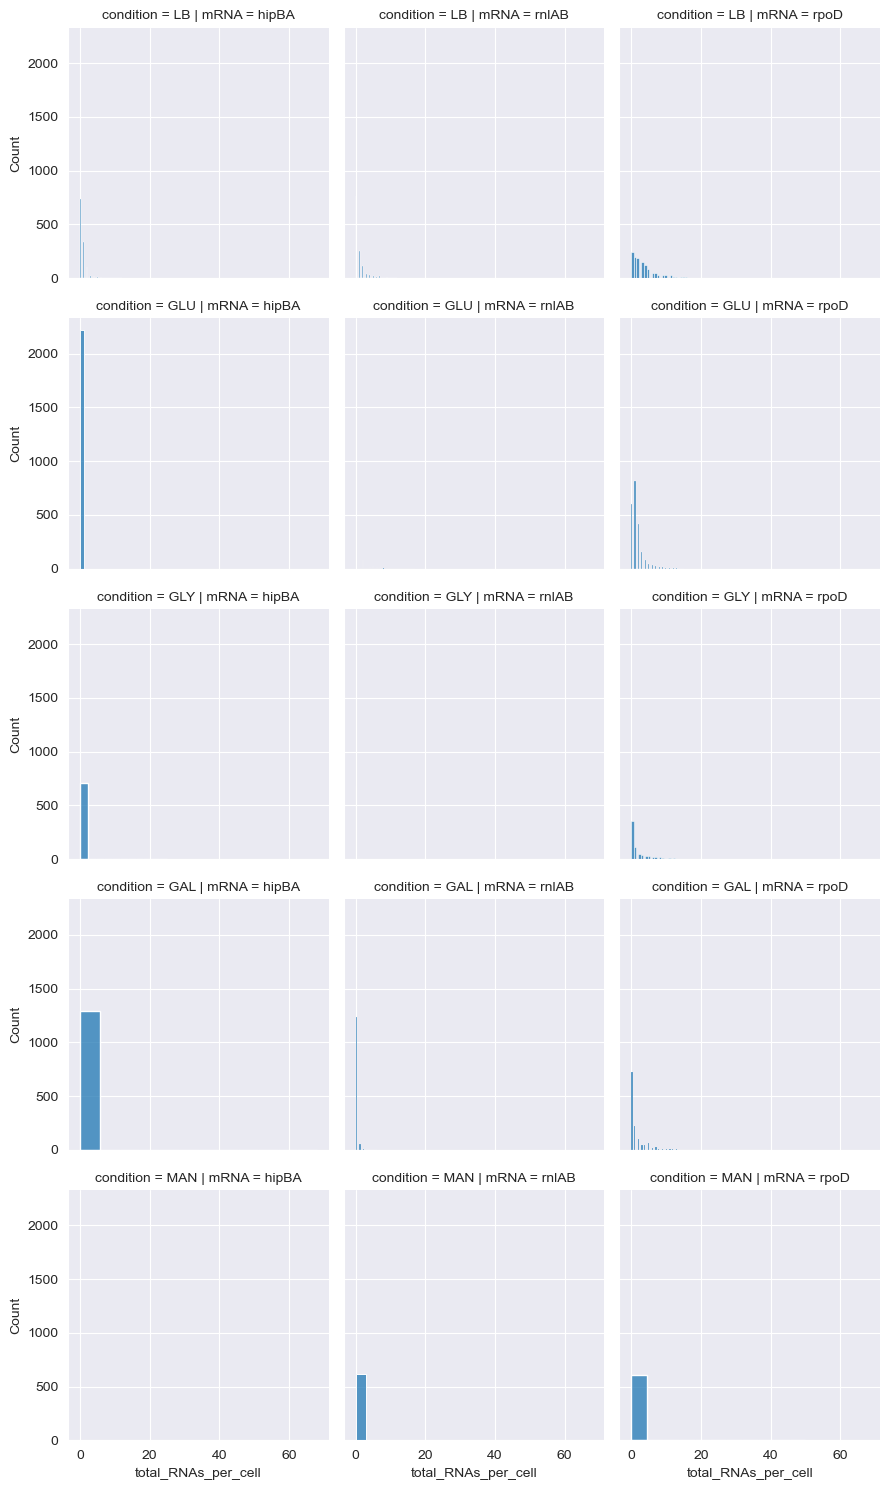

In [48]:
g = sns.FacetGrid(df, col='mRNA', row='condition', row_order=conditions_ordered )
g.map_dataframe(sns.histplot, x='total_RNAs_per_cell');

In [58]:
df.columns

Index(['cell_image_id', 'cell_unique_id', 'strain', 'condition', 'seqnr',
       'mRNA', 'label', 'bbox-0', 'bbox-1', 'bbox-2', 'bbox-3', 'area',
       'eccentricity', 'spots_per_cell', 'dense_regions_per_cell',
       'decomposed_RNAs', 'tx_per_cell', 'nascent_RNAs', 'nuclei',
       'total_RNAs_per_cell'],
      dtype='object')

### Txs per cell:

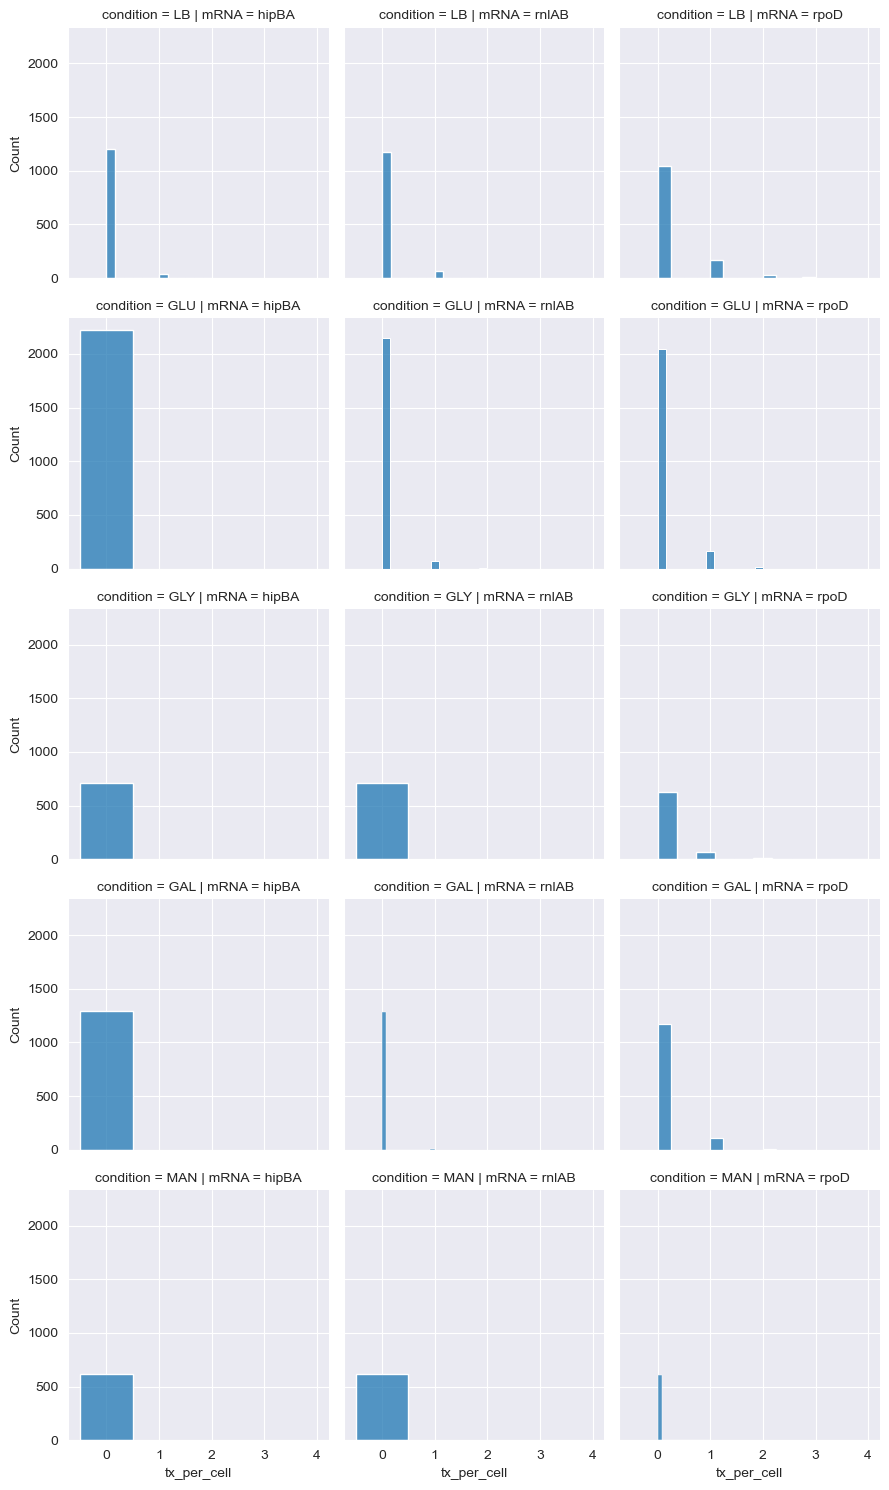

In [59]:
g = sns.FacetGrid(df, col='mRNA', row='condition', row_order=conditions_ordered )
g.map_dataframe(sns.histplot, x='tx_per_cell');

### <span style="color:seagreen"> 5.3.1 - Plotting only expressing cells </span>

In [ ]:
ax=sns.stripplot(
    data=df[df['total RNAs per cell']>0],
    x="condition", y="total RNAs per cell", orient="v",palette='viridis' ,hue='mRNA',dodge=True, s=3, alpha=0.5
)
ax.set_title('RNAs_per_cell')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_ylim(0,85)

# plot the mean line
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 1},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="condition",
            y="total RNAs per cell",
            hue='mRNA',
            data=df[df['total RNAs per cell']>0],
            showfliers=False,
            showbox=False,
            showcaps=False)
plt.legend(title='mRNA', loc='upper right', labels=['CLB2Q670', 'EFG1Q670'],markerscale=5)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

#plt.savefig('FV_stripplot_total_RNAs.svg')

### <span style="color:seagreen"> 5.3.2 - Plotting nascent mRNA per cell </span>

In [ ]:
ax=sns.stripplot(
    data=df[df['nascent RNAs']>0],
    x="condition", y="nascent RNAs", orient="v",palette='viridis' ,hue='mRNA',dodge=True, s=3, alpha=0.5
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

ax.set_title('nascent RNAs per cell')
ax.set_ylim(0,35)

# plot the mean line
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 1},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="condition",
            y="nascent RNAs",
            hue='mRNA',
            data=df[df['nascent RNAs']>0],
            showfliers=False,
            showbox=False,
            showcaps=False)
plt.legend(title='mRNA', loc='upper right', labels=['CLB2Q670', 'EFG1Q670'],markerscale=5)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

#plt.savefig('FV_nascent_stripplot.svg')